<a href="https://colab.research.google.com/github/gustavofg1pontes/Transfer-Learning/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# **Transfer Learning**
O transfer learning consiste na técnica de utilizar um modelo de IA já treinado, com pesos definidos, para retreiná-lo de acordo com uma nova - e menor - base de dados. No exemplo, é carregado um modelo do keras utilizando os pesos treinados do imagenet e utilizamos para a classificação de imagens para reconhecer gatos ou cachorros.

In [ ]:
# Carrega o dataset utilizado de gatos e cachorros
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Divide entre os datasets (traning(primeiros 40%), validation(40%-50%), test(50%-60%))
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True
)

print(f"Número de amostras (training): {train_ds.cardinality()}")
print(f"Número de amostras (validation): {validation_ds.cardinality()}")
print(f"Número de amostras (test): {test_ds.cardinality()}")

Número de amostras (training): 9305
Número de amostras (validation): 2326
Número de amostras (test): 2326


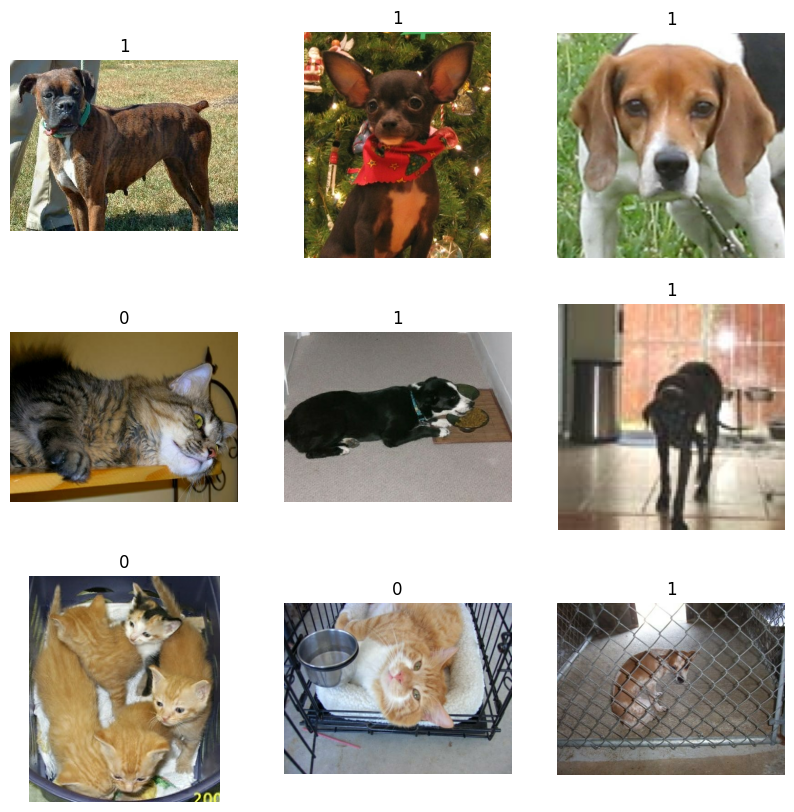

In [ ]:
# mostra as primeiras imagens do dataset de treino
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
# Redimensiona as imagens de todos os ds
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [ ]:
# Data augmentation serve para termos diferentes amostras, muito util para datasets pequenos em que não há muita variedade de imagens
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
from tensorflow import data as tf_data
# Define o número de amostras que serão carregadas de uma vez durante o treinamento
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

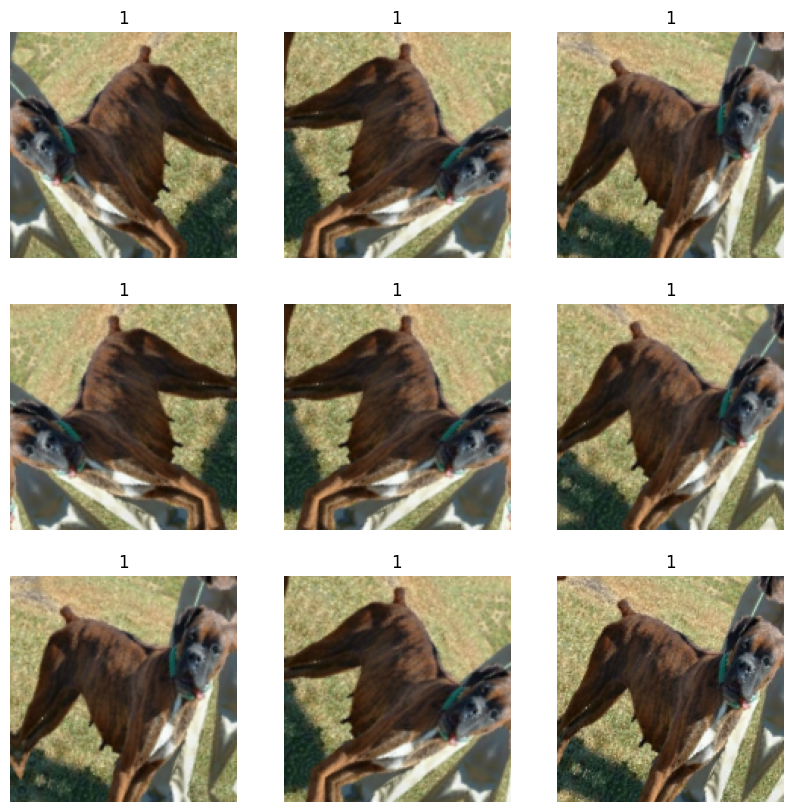

In [ ]:
# Mostra a primeira imagem após o data augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
# Modelo pré-treinado
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False # Exclui as camadas densas (totalmente conectadas)
)

base_model.trainable = False

# Criação de novo modelo
inputs = keras.Input(shape=(150, 150, 3))

# Reescala as entradas para o padrão do Xception (-1., +1.)
# As entradas diminuem aproximadamente até a metade de seu tamanho original (scale = 1 / 127.5)
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False) # training = False define que as camadas BatchNormalization estão em inference mode
x = keras.layers.GlobalAveragePooling2D()(x) # Camada de pooling (reduz a dimensionalidade)
x = keras.layers.Dropout(0.2)(x) # Camada de normalização (Remove algumas "características" para reduzir o overfitting)
outputs = keras.layers.Dense(1)(x) # Camada da resposta (1 pois é possível apenas uma saída: gato(0) ou cachorro(1))
model = keras.Model(inputs, outputs) # Cria o modelo

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
# Compila e treina o modelo criado
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2


In [ ]:
# Avalia o modelo usando o dataset de testes
model.evaluate(test_ds)

# **Fine-Tuning**
O fine-tuning consiste em "descongelar" algumas ou todas as camadas do modelo-base para treiná-lo com uma taxa de aprendizado baixa. Esse passo é opcional e pode tanto melhorar muito a acurácia quanto levar o modelo ao overfitting.

In [ ]:
# Descongela modelo base
base_model.trainable = True

model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5), # Taxa de aprendizado baixa
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

In [ ]:
# Avalia o modelo depois do fine-tuning
model.evaluate(test_ds)